# "Managing Investor Decisions with Reinforcement Learning"

> RL is used to provide optimal investment decisions for a typical home owner
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InvestorProject_1.png
- categories: [Investment_Industry,  Reinforcement_Learning,DDPG,  OpenAI,Gym,TensorFlow,TF-Agents]
- show_tags: true

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'RL/TF-Agents/InvestorProject/'
# base_dir = root_dir + 'InvestorProject/'
# base_dir = ""

Mounted at /content/gdrive


In [ ]:
#hide
# Compared with InvestorProject.ipynb, this notebook's main difference is that it 
# removes the percentaging of the actions before applying them. It assumes the 
# agent will eventually learn not to exceed the investor's salary. It also makes 
# obvious in the code that STATES are stored in the Investor in terms of dollars, 
# although normalized to M$ when step() returns, whereas ACTIONS come in as M$ 
# (but are first converted to dollars). It is just easier to work with dollars in 
# the code.

## 1. Purpose
This project's purpose is to answer the need of a client who wanted a 'feel' for the factors involved in long-term investment for a typical home owner (i.e. not for a professional investor). He wanted an AI model to play with that includes adjusting the:

* starting age of the investor
* retirement age of the investor
* inflation rate
* tax rate
* investor's salary at the time the investment starts
* expected expenses of the investor
* size of a home mortgage
* mortgage interest rate
* investment return interest rate
* tax deferred contributions limit
* company match on tax deferred contributions

He was interested to find out what his optimal investment plan would be when model parameters were adjusted.

## 2. Solution Proposal  

Investment decisions are sequential by nature. Furthermore, an optimal decision in the present may turn out not to be optimal over the longer term. Then there are the complexities of the investment landscape like varying interest rates, inflation, and other economic uncertainties. The ideal tool for this kind of problem is **Reinforcement Learning**.

The solution requires the setup of a digital twin for the investor, the client in this case. In RL parlance this model of the investor is called an **environment**. The environment contains **states** which are modified by applying **actions** to it. 

The present solution was inspired by the suggestion of [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, Washington University in St. Louis.

We will choose the following **states** for the environment:

$$ \Large
\begin{aligned}
s_1 &= \text{Age} \\
s_2 &= \text{Salary} \\
s_3 &= \text{Home Value} \\
s_4 &= \text{Home Loan Amount} \\
s_5 &= \text{Home Required Payment} \\
s_6 &= \text{Tax Deferred Savings} \\
s_7 &= \text{Taxable Savings}
\end{aligned}
$$

The following **actions** (applied monthly) will be setup to influence the environment/investor:

$$ \Large
\begin{aligned}
a_1 &= \text{Home Loan Payment Amount} \\
a_2 &= \text{Tax Deferred Deposit Amount} \\
a_3 &= \text{Taxable Deposit Amount} \\
a_4 &= \text{Luxury Spending Amount}
\end{aligned}
$$

The values of all states and actions will be in terms of millions, i.e. M$ (mega-dollars) in the case of monetary amounts. Neural networks work better with smaller numbers.

The model of the environment/investor will have the following **parameters**:

$$ \Large
\begin{aligned}
\theta_1 &= \text{Investor Start Age} \\
\theta_2 &= \text{Investor Retire Age} \\
\theta_3 &= \text{Inflation Rate} \\
\theta_4 &= \text{Tax Rate} \\
\theta_5 &= \text{Low Value of Investor's Salary when investment starts} \\
\theta_6 &= \text{High Value of Investor's Salary when investment starts} \\
\theta_7 &= \text{Expenses of the Investor (as fraction of salary)} \\
\theta_8 &= \text{Low Value of House Price (as multiple of salary)} \\
\theta_9 &= \text{High Value of House Price (as multiple of salary)} \\
\theta_{10} &= \text{Mortgage Interest Rate} \\
\theta_{11} &= \text{Investment Return Rate} \\
\theta_{12} &= \text{Tax Deferred Contributions Limit (government's annual cap)} \\
\theta_{13} &= \text{Company Match on Tax Deferred Contributions}
\end{aligned}
$$

Rather than having the investor's salary directly as a parameter, we will have two parameters, one for the low value and one for the high value. This makes the model more flexible, in particular during training. The same applies for the two parameters used for the house price. In addition, we will add some variability for the interest rates. The latter variabilities may be considered *disturbances* experienced by the investor. The agent has the ability to incorporate such disturbances during its operation.


## 3. Implementation of the Solution
To implement the *environment* we use the OpenAI Gym tools. We will use the TF-Agents python library from Google to implement the *agent*. Because we have *continuous* actions we will use the Deep Deterministic Policy Gradients (DDPG) network as a function approximator for the agent.

This implementation allows the agent to allocate the investor's income between several targets, namely, tax-deferred savings, taxable savings, buying luxury items, and paying off the mortgage. The goal is to maximize net worth at the end of the investment horizon.

The code will run on the Google Colab platform. To start with, we install the python packages needed.

In [ ]:
!sudo apt-get install -y xvfb ffmpeg x11-utils
!pip install -q 'gym==0.10.11'
!pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (1,533 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back t

Import the packages needed:

In [ ]:
import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy as np
import matplotlib as mpl
import pickle
import tensorflow as tf
from tf_agents.agents.ddpg import actor_network
from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.ddpg import ddpg_agent
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.utils import common
import gym
from gym import spaces
from gym.utils import seeding
from gym.envs.registration import register

### 3.1 The Environment/Investor

Next, we will implement the investor using OpenAI Gym:

In [ ]:
#hide
    # def _eval_action(self, action, home_req_payment): #---------------------------------------------
    #   # Calculate actions
    #   act_home_loan = action[Investor.ACT_HOME_LOAN]
    #   act_save_tax_adv = action[Investor.ACT_SAVE_TAX_DEF]
    #   act_save_taxable = action[Investor.ACT_SAVE_TAXABLE]
    #   act_luxury = action[Investor.ACT_LUXURY]
    #   if home_req_payment <=0: act_home_loan = 0
    #   total_act = act_home_loan + act_save_tax_adv + act_save_taxable + \
    #         act_luxury + self.expenses
    #   if total_act < 1e-2: #to avoid division by zero
    #     pct_home_loan = 0
    #     pct_save_tax_def = 0
    #     pct_save_taxable = 0
    #     pct_luxury = 0
    #   else:
    #     pct_home_loan = act_home_loan/total_act
    #     pct_save_tax_def = act_save_tax_adv/total_act
    #     pct_save_taxable = act_save_taxable/total_act
    #     pct_luxury = act_luxury/total_act
    #     pct_expenses = self.expenses/total_act #not an action!
    #   if self.verbose: print(f"calced actions: pct_home_loan={pct_home_loan:.2f}, pct_save_tax_def={pct_save_tax_def:.2f}, pct_save_taxable={pct_save_taxable:.2f}, pct_luxury={pct_luxury:.2f}")
    #   if self.verbose: print(f"pct_expenses: {pct_expenses:.2f}")
    #   return pct_home_loan, pct_save_tax_def, pct_save_taxable, pct_luxury

In [ ]:
class Investor(gym.Env):
    NUM_STATE_ELEMENTS = 7
    STATES = [
      #states proper:
      'sta_age','sta_salary','sta_home_value','sta_home_loan','sta_home_req_payment','sta_save_tax_def','sta_save_taxable', 
      #append to self.state_log in step() function for visualization purposes:
      "expenses","home_actual_pmt","deposit_taxable","deposit_tax_def","luxury_spend","net_worth",
      #append action vector for visualization purposes:
      "a_home_loan", "a_save_tax_def", "a_save_taxable", "a_luxury"
      ]
    MEG = 1.0e6 #for normalization
    # STATES
    STA_AGE = 0
    STA_SALARY = 1
    STA_HOME_VALUE = 2
    STA_HOME_LOAN = 3
    STA_HOME_REQ_PAYMENT = 4
    STA_SAVE_TAX_DEF = 5
    STA_SAVE_TAXABLE = 6
    # ACTIONS
    NUM_ACTION_ELEMENTS = 4
    ACT_HOME_LOAN = 0
    ACT_SAVE_TAX_DEF = 1
    ACT_SAVE_TAXABLE = 2
    ACT_LUXURY = 3
    # PARAMETERS
    PAR_START_AGE = 18
    PAR_RETIRE_AGE = 80
    PAR_INFLATION = 0.05/12.0 #per month
    PAR_TAX_RATE = 0.142/12.0 #per month
    PAR_SALARY_LOW = 40000 #per year
    PAR_SALARY_HIGH = 60000 #per year
    PAR_EXPENSES = 0.6 #(of salary)
    PAR_HOUSE_MULT_LOW = 1.5 #(of salary)
    PAR_HOUSE_MULT_HIGH = 4.0 #(of salary)
    PAR_MORT_INT = 0.05/12.0 #per month
    PAR_INVEST_INT = 0.065/12.0 #per month
    PAR_TAX_DEF_DEPOSIT_CAP = 19000 #per year
    PAR_TAX_DEF_COMPANY_MATCH = 1.05 #company match
    PAR_ACTION_SPACE_LOW = 0.0 #in millions, i.e. $0
    PAR_ACTION_SPACE_HIGH = 0.01 #in millions, i.e. $10,000
    PAR_OBSERVATION_SPACE_LOW = 0.0 #in millions, i.e. $0
    PAR_OBSERVATION_SPACE_HIGH = 10.0 #in millions, i.e. $10,000,000

    def __init__(self, goal_velocity=0):
      self.verbose = False
      self.viewer = None
      self.inflation = None
      self.invest_return = None
      self.year_tax_def_deposit_left = None
      self.expenses = None
      self.ke_expenses = None
      self.ke_home_actual_pmt = None
      self.ke_deposit_taxable = None
      self.ke_deposit_tax_def = None
      self.ke_luxury_spend = None
      self.ke_networth = None
      self.action_space = spaces.Box(
          low=Investor.PAR_ACTION_SPACE_LOW,
          high=Investor.PAR_ACTION_SPACE_HIGH,
          shape=(Investor.NUM_ACTION_ELEMENTS,),
          dtype=np.float32
      )
      self.observation_space = spaces.Box(
          low=Investor.PAR_OBSERVATION_SPACE_LOW,
          high=Investor.PAR_OBSERVATION_SPACE_HIGH,
          shape=(Investor.NUM_STATE_ELEMENTS,),
          dtype=np.float32
      )
      self.seed()
      self.reset()
      self.state_log = []

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed) #rng, seed
        return [seed]

    def _calc_net_worth(self):
      worth = self.state[Investor.STA_HOME_VALUE] - self.state[Investor.STA_HOME_LOAN] # 'under-water' when negative
      worth += self.state[Investor.STA_SAVE_TAX_DEF]
      worth += self.state[Investor.STA_SAVE_TAXABLE]
      return worth

    def step(self, action):
      if self.verbose: print(f"step with action: {action}")
      # self.last_action = action #not used explicitly
      sta_age = self.state[Investor.STA_AGE]
      sta_salary = self.state[Investor.STA_SALARY]
      sta_home_value = self.state[Investor.STA_HOME_VALUE]
      sta_home_loan = self.state[Investor.STA_HOME_LOAN]
      sta_home_req_payment = self.state[Investor.STA_HOME_REQ_PAYMENT]
      act_save_tax_def = action[Investor.ACT_SAVE_TAX_DEF]*1e6
      act_home_loan = action[Investor.ACT_HOME_LOAN]*1e6
      act_save_taxable = action[Investor.ACT_SAVE_TAXABLE]*1e6
      act_luxury = action[Investor.ACT_LUXURY]*1e6
      net1 = self._calc_net_worth()
      remaining_salary = sta_salary
      if self.verbose: print(f"Available Salary: {sta_salary:,.2f}")
      # pct_home_loan, pct_save_tax_def, pct_save_taxable, pct_luxury = self._eval_action(action, sta_home_req_payment) #---
      # 1. Expenses
      current_expenses = self.expenses*sta_salary
      remaining_salary -= current_expenses
      if self.verbose:
        print(f"Expenses: {current_expenses:,.2f}")
        print(f"---Remaining Salary after expenses: {remaining_salary:,.2f}")
      # 2. Tax deferred deposit action
      # my_tax_def_deposit = min(pct_save_tax_def*sta_salary, remaining_salary)
      my_tax_def_deposit = min(act_save_tax_def, remaining_salary) #---
      my_tax_def_deposit = min(my_tax_def_deposit, self.year_tax_def_deposit_left) #Govt CAP
      self.year_tax_def_deposit_left -= my_tax_def_deposit
      remaining_salary -= my_tax_def_deposit
      deposit_tax_def = Investor.PAR_TAX_DEF_COMPANY_MATCH*my_tax_def_deposit
      self.state[Investor.STA_SAVE_TAX_DEF] += int(deposit_tax_def)
      if self.verbose:
        print(f"IRA Deposit (deposit_tax_def): {deposit_tax_def:,.2f}")
        print(f"---Remaining Salary after deposit_tax_def: {remaining_salary:,.2f}")
      # 3. Tax
      tax = Investor.PAR_TAX_RATE*remaining_salary
      remaining_salary -= tax
      if self.verbose:
        print(f"tax: {tax:,.2f}")
        print(f"---Remaining Salary after tax: {remaining_salary:,.2f}")
      # 4. Home
      # home_actual_payment = min(pct_home_loan*sta_salary, remaining_salary)
      if sta_home_loan > 0:
        home_actual_payment = min(act_home_loan, remaining_salary) #---
        ipart = Investor.PAR_MORT_INT*sta_home_loan
        ppart = home_actual_payment - ipart
        principal = int(sta_home_loan - ppart)
        if principal <= 0:
          principal = 0
          self.state[Investor.STA_HOME_REQ_PAYMENT] = 0
        elif home_actual_payment < sta_home_req_payment:
          self.late_count += 1
          if self.late_count > 15: #foreclose
            sell = (sta_home_value - principal)/2
            sell -= 20000 #fees for selling
            sell = max(sell, 0)
            self.state[Investor.STA_SAVE_TAXABLE] += sell
            principal = 0
            #sta_home_value = 0 #nothing done with it
            self.expenses += .3 #for rent
            self.state[Investor.STA_HOME_REQ_PAYMENT] = 0
            self.state[Investor.STA_HOME_VALUE] = 0
            #self.state[Investor.STA_HOME_LOAN] = 0 #see couple lines down
            if self.verbose: print(f"Foreclosure!!")
          else:
            late_fee = 0.10*sta_home_req_payment
            principal += late_fee
            if self.verbose: print(f"Late Fee: {late_fee:,.2f}")
        self.state[Investor.STA_HOME_LOAN] = principal
        remaining_salary -= home_actual_payment
      else: home_actual_payment = 0.0 #---
      if self.verbose:
        print(f"sta_home_loan: {sta_home_loan:,.2f}")
        print(f"Home Payment: {home_actual_payment:,.2f}")
        print(f"---Remaining Salary after home payment: {remaining_salary:,.2f}")
      # 5. Taxable savings
      # actual_savings = pct_save_taxable*remaining_salary
      actual_savings = min(act_save_taxable, remaining_salary) #---
      self.state[Investor.STA_SAVE_TAXABLE] += actual_savings
      remaining_salary -= actual_savings
      if self.verbose:
        print(f"actual_savings: {actual_savings:,.2f}")
        print(f"---Remaining Salary after actual_savings (goes to Luxury): {remaining_salary:,.2f}")
      # 6. Luxury spend
      # luxury_spend = remaining_salary
      luxury_spend = min(act_luxury, remaining_salary) #updated lower #---
      remaining_salary -= luxury_spend
      if self.verbose:
        print(f"luxury_spend: {luxury_spend:,.2f}")
        print(f"---Remaining Salary after luxury_spend: {remaining_salary:,.2f}")
      # 7. Investment income
      return_taxable = self.invest_return*self.state[Investor.STA_SAVE_TAXABLE]
      return_tax_adv = self.invest_return*self.state[Investor.STA_SAVE_TAX_DEF]
      return_taxable *= 1 - Investor.PAR_TAX_RATE
      self.state[Investor.STA_SAVE_TAXABLE] += return_taxable
      self.state[Investor.STA_SAVE_TAX_DEF] += return_tax_adv
      # Yearlies
      if sta_age>0 and sta_age % 12 == 0: self.perform_yearly()
      # Monthlies
      self.state[Investor.STA_AGE] += 1
      # Time to retire?
      done = self.state[Investor.STA_AGE] > (Investor.PAR_RETIRE_AGE*12)
      # Calculate reward 
      net2 = self._calc_net_worth()
      reward = net2 - net1
      # Track progress
      if self.verbose:
        print(f"Networth: {net2:,.2f}")
        print(f"*** End Step {self.step_num}: \nState={self.state}, Reward={reward}\n")
      log_entry = self.state + \
        [current_expenses,home_actual_payment,actual_savings,my_tax_def_deposit,luxury_spend,net2] + \
        list(action)
      self.state_log.append(log_entry); #print(f"******* log_entry={log_entry}")
      # Capture so that render() can get them
      self.ke_expenses = current_expenses
      self.ke_home_actual_pmt = home_actual_payment
      self.ke_deposit_taxable = actual_savings
      self.ke_deposit_tax_def = my_tax_def_deposit
      self.ke_luxury_spend = luxury_spend
      self.ke_networth = net2
      
      self.step_num += 1
      norm_state = [x/Investor.MEG for x in self.state] #normalize
      return norm_state, reward/Investor.MEG, done, {}

    def perform_yearly(self):
      self.inflation = Investor.PAR_INFLATION + self.np_random.normal(loc=0, scale=1e-2)
      self.invest_return = Investor.PAR_INVEST_INT + self.np_random.normal(loc=0, scale=1e-2) #loc is mean, scale is stdev
      self.year_tax_def_deposit_left = Investor.PAR_TAX_DEF_DEPOSIT_CAP
      self.state[Investor.STA_SALARY] = int((1 + self.inflation)*self.state[Investor.STA_SALARY])
      self.state[Investor.STA_HOME_VALUE] = int((1 + self.inflation)*self.state[Investor.STA_HOME_VALUE])

    def reset(self):
      self.expenses = Investor.PAR_EXPENSES
      self.late_count = 0
      self.step_num = 0
      self.state = [0]*Investor.NUM_STATE_ELEMENTS
      self.state_log = []

      self.ke_expenses = 0
      self.ke_home_actual_pmt = 0
      self.ke_deposit_taxable = 0
      self.ke_deposit_tax_def = 0
      self.ke_luxury_spend = 0
      self.ke_networth = 0

      salary = float(self.np_random.randint(low=Investor.PAR_SALARY_LOW, high=Investor.PAR_SALARY_HIGH)) #discrete-uniform (inclusive, exclusive)
      house_mult = self.np_random.uniform(low=Investor.PAR_HOUSE_MULT_LOW, high=Investor.PAR_HOUSE_MULT_HIGH) #uniform (inclusive, exclusive) 
      value = round(house_mult*salary)
      p = (0.9*value)
      i = Investor.PAR_MORT_INT
      n = 30*12
      m = float(int(p * ( i * (1 + i)**n ) / ( (1 + i)**n - 1)))
      self.state[Investor.STA_AGE] = Investor.PAR_START_AGE*12
      self.state[Investor.STA_SALARY] = salary/12.0
      self.state[Investor.STA_HOME_VALUE] = value
      self.state[Investor.STA_HOME_LOAN] = p
      self.state[Investor.STA_HOME_REQ_PAYMENT] = m
      self.year_tax_def_deposit_left = Investor.PAR_TAX_DEF_DEPOSIT_CAP #19000
      self.perform_yearly()
      return np.array(self.state)

    def render(self, mode='human'):
        # sta_age = self.state[Investor.STA_AGE]
        # sta_salary = self.state[Investor.STA_SALARY]*12
        # sta_home_value = self.state[Investor.STA_HOME_VALUE]
        # sta_home_loan = self.state[Investor.STA_HOME_LOAN]
        # sta_home_req_payment = self.state[Investor.STA_HOME_REQ_PAYMENT]
        # sta_save_tax_def = self.state[Investor.STA_SAVE_TAX_DEF]
        # sta_save_taxable = self.state[Investor.STA_SAVE_TAXABLE]
        # net_worth = self._calc_net_worth()
        return (self.ke_expenses,self.ke_home_actual_pmt,self.ke_deposit_taxable,self.ke_deposit_tax_def,self.ke_luxury_spend,self.ke_networth)

    def close(self):
        pass

Register the investor:

In [ ]:
env_name = 'investor-v0'
register(
    id=env_name,
    entry_point=f'{__name__}:Investor'
)

#### 3.1.1 Play with the Environment/Investor

To provide a level of confidence, and test the investor (in an informal way), we can run some simulations on it. This will not involve the operation of the agent for now. We simply run the simulation with fixed actions. The ```state_log``` is then loaded into a Pandas dataframe for easy viewing.

In [ ]:
import pandas as pd
def run_episode(pol=[0.001, 0.001, 0.001, 0.001], rand=False):
  env.reset()
  done = False
  i = 0 #for pre-mature break
  while not done:
      # if i>1: break
      if rand==True: 
        sample = env.action_space.sample(); #print(f"***sample: {sample}")
        state, reward, done, _ = env.step(sample)
      else: 
        state, reward, done, _ = env.step(pol)
      #ke_expenses,ke_home_actual_pmt,ke_deposit_taxable,ke_deposit_tax_adv,ke_luxury_spend,ke_networth = env.render() #not used here
      i += 1
  df = pd.DataFrame(env.state_log, columns=Investor.STATES)
  # df = df.round(0)
  df['sta_age'] = df['sta_age']/12; df['sta_age'] = df['sta_age'].round(2)
  print(f"Net Worth: {env._calc_net_worth():,.2f}")
  print(f"step_num: {env.step_num}")
  return df

In [ ]:
env = gym.make(env_name)

In [ ]:
env.verbose = False
Investor.PAR_START_AGE = 30
Investor.PAR_RETIRE_AGE = 50
Investor.PAR_SALARY_LOW = 80000; Investor.PAR_SALARY_HIGH = 80001
Investor.PAR_HOUSE_MULT_LOW = 2.0; Investor.PAR_HOUSE_MULT_HIGH = 2.0

In [ ]:
# ACT_HOME_LOAN, ACT_SAVE_TAX_DEF, ACT_SAVE_TAXABLE, ACT_LUXURY
df = run_episode(pol=[.0009, .0015, .001, .04], rand=False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 12)
display(df)

Net Worth: 1,190,280.41
step_num: 241


,sta_age,sta_salary,sta_home_value,sta_home_loan,sta_home_req_payment,sta_save_tax_def,sta_save_taxable,expenses,home_actual_pmt,deposit_taxable,deposit_tax_def,luxury_spend,net_worth,a_home_loan,a_save_tax_def,a_save_taxable,a_luxury
0,30.08,6875,165011,143700,773.0,1579.397920,280.246887,4040.4,900.0,279.475733,1500.0,0.0,2.317064e+04,0.0009,0.0015,0.001,0.04
1,30.17,6875,165011,143398,773.0,3141.637981,612.995086,4125.0,900.0,335.208333,1500.0,0.0,2.536763e+04,0.0009,0.0015,0.001,0.04
2,30.25,6875,165011,143095,773.0,4697.558582,944.413205,4125.0,900.0,335.208333,1500.0,0.0,2.755797e+04,0.0009,0.0015,0.001,0.04
3,30.33,6875,165011,142791,773.0,6247.185288,1274.506559,4125.0,900.0,335.208333,1500.0,0.0,2.974169e+04,0.0009,0.0015,0.001,0.04
4,30.42,6875,165011,142485,773.0,7790.543557,1603.280444,4125.0,900.0,335.208333,1500.0,0.0,3.191982e+04,0.0009,0.0015,0.001,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,49.75,7704,185079,22906,773.0,778888.164209,224809.414082,4622.4,900.0,662.884400,1500.0,0.0,1.165871e+06,0.0009,0.0015,0.001,0.04
237,49.83,7704,185079,22101,773.0,782667.106621,226101.473143,4622.4,900.0,662.884400,1500.0,0.0,1.171747e+06,0.0009,0.0015,0.001,0.04
238,49.92,7704,185079,21293,773.0,786456.720352,227397.137662,4622.4,900.0,662.884400,1500.0,0.0,1.177640e+06,0.0009,0.0015,0.001,0.04
239,50.00,7704,185079,20481,773.0,790257.035537,228696.417700,4622.4,900.0,662.884400,1500.0,0.0,1.183551e+06,0.0009,0.0015,0.001,0.04


In [ ]:
env.close()

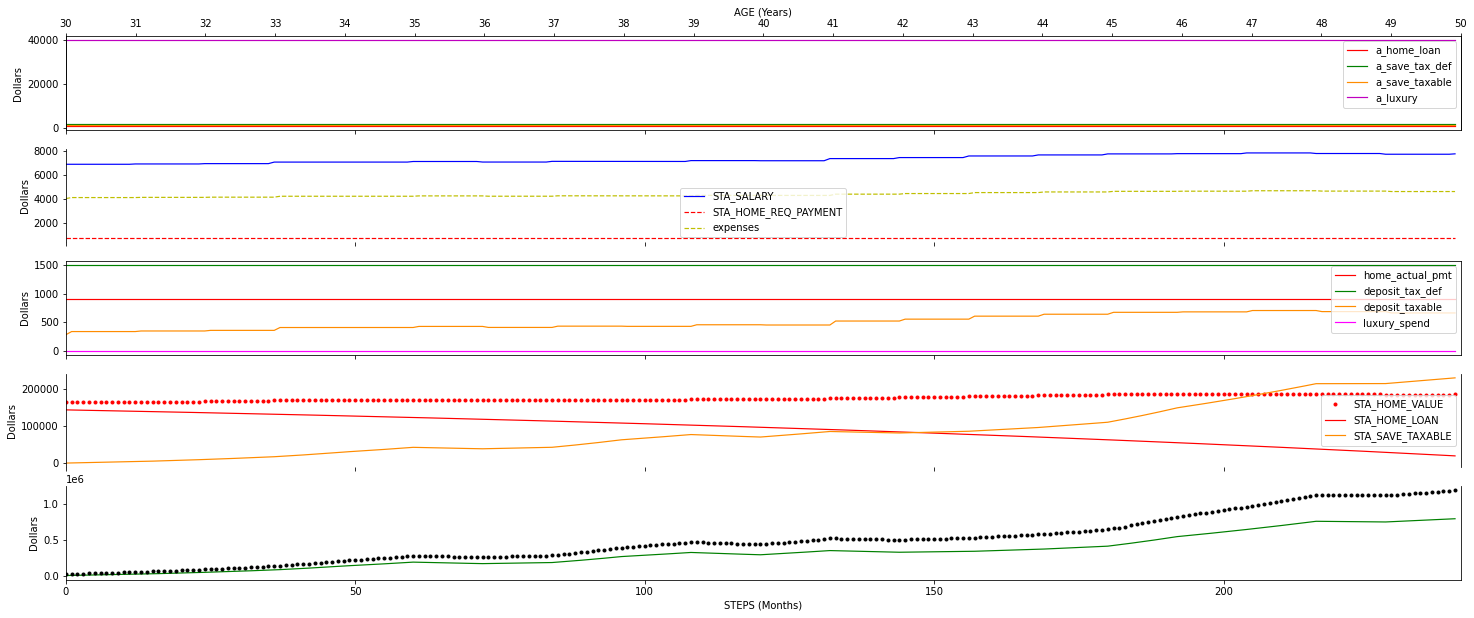

In [ ]:
mpl.rcParams['lines.linewidth'] = 1.2
t = np.arange(0, len(df)); fig,(axs0,axs1,axs2,axs3,axs4) = plt.subplots(5, sharex=True)
fig.set_figwidth(25); fig.set_figheight(10)
axs0.set_xlim(0, len(df)); 
axs0.set_ylim(auto=True); axs0.spines['top'].set_visible(False); axs0.spines['right'].set_visible(True); axs0.spines['bottom'].set_visible(False)
axs0.set_ylabel('Dollars');axs1.set_ylabel('Dollars');axs2.set_ylabel('Dollars');axs3.set_ylabel('Dollars');axs4.set_ylabel('Dollars');
axs0.plot(t, df.a_home_loan*1e6, 'r-', label='a_home_loan')
axs0.plot(t, df.a_save_tax_def*1e6, 'g-', label='a_save_tax_def')
axs0.plot(t, df.a_save_taxable*1e6, '-', color='darkorange', label='a_save_taxable')
axs0.plot(t, df.a_luxury*1e6, 'm-', label='a_luxury')

axs1.set_ylim(auto=True); axs1.spines['top'].set_visible(False); axs1.spines['right'].set_visible(False); axs1.spines['bottom'].set_visible(False)
axs1.plot(t, df.sta_salary, 'b-', label='STA_SALARY')
axs1.plot(t, df.sta_home_req_payment, 'r--', label='STA_HOME_REQ_PAYMENT')
axs1.plot(t, df.expenses, 'y--', label='expenses')

axs2.set_ylim(auto=True); axs3.spines['top'].set_visible(False); axs3.spines['right'].set_visible(True); axs3.spines['bottom'].set_visible(False)
axs2.plot(t, df.home_actual_pmt, 'r-', label='home_actual_pmt')
axs2.plot(t, df.deposit_tax_def, 'g-', label='deposit_tax_def')
axs2.plot(t, df.deposit_taxable, '-', color='darkorange', label='deposit_taxable')
axs2.plot(t, df.luxury_spend, '-', color='magenta', label='luxury_spend')

axs3.set_ylim(auto=True); axs4.spines['top'].set_visible(False); axs4.spines['right'].set_visible(True); axs4.spines['bottom'].set_visible(True)
axs3.plot(t, df.sta_home_value, 'r.', label='STA_HOME_VALUE')
axs3.plot(t, df.sta_home_loan, 'r-', label='STA_HOME_LOAN')
axs3.plot(t, df.sta_save_taxable, '-', color='darkorange', label='STA_SAVE_TAXABLE')

axs4.plot(t, df.sta_save_tax_def, 'g-', label='STA_SAVE_TAX_DEF')
axs4.plot(t, df.net_worth, 'k.', label='net_worth')
axs4.set_xlabel('STEPS (Months)')

axs0.legend(); axs1.legend(); axs2.legend(); axs3.legend()
axs_years = axs0.twiny()
years_tick_locations = np.arange(0, len(df), 12)
axs_years.set_xticks(years_tick_locations)
axs_years.set_xticklabels(range(Investor.PAR_START_AGE, Investor.PAR_START_AGE + len(years_tick_locations)))
axs_years.set_xlabel('AGE (Years)'); axs0.spines['bottom'].set_visible(False)

### 3.2 Agent

Now we will implement the agent.

#### 3.2.1 Hyperparameters

The following hyperparamaters need to be specified to train the agent:

In [ ]:
num_iterations = 60000 
initial_collect_steps = 1000 #How many initial random steps, before training start, to collect initial data.
collect_steps_per_iteration = 50 #How many steps should we run each iteration to collect data from.
replay_buffer_max_length = 100000 #How much data should we store for training examples.
batch_size = 64
#learning_rate = 1e-4 #How often should the program provide an update.
log_interval = 2500 #log entry occurs each 2500 steps 
num_eval_episodes = 100 #episodes used for each evaluation
eval_interval = 5000 #evaluation occurs once every 5000 steps

#### 3.2.2 Setup the TF-Agents framework to implement the Agent
We instantiate two environments: One for training and one for evaluation:

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

Next we wrap the python environments with TensorFlow environments:

In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

To provide a continuous action space we will use the Deep Deterministic Policy Gradients (DDPG) algorithm. [[Cite:lillicrap2015continuous]](https://arxiv.org/abs/1509.02971) The algorithm uses two neural networks.  The one, called an *actor*, acts as the agent and predicts the expected reward for a given value of the action.  The second neural network, called a *critic*, is trained to predict the accuracy of the actor-network.  This technique of training two neural networks in parallel that operate adversarially to each other is quite  popular. Figure 1 shows the structure of the DDPG network that we will use.

*Figure 1: DDPG: Actor Critic Model*
![Deep Q-Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/actor-critic.png "Actor Critic Model")

The environment provides the same input ($x(t)$) for each time step to both the actor and critic networks. The temporal difference error ($r(t)$) reports the difference between the estimated reward at any given state or time step and the actual reward. 

The following code creates the actor and critic neural networks:

In [ ]:
actor_fc_layers = (400, 300)
critic_obs_fc_layers = (400,)
critic_action_fc_layers = None
critic_joint_fc_layers = (300,)
ou_stddev = 0.2
ou_damping = 0.15
target_update_tau = 0.05
target_update_period = 5
dqda_clipping = None
td_errors_loss_fn = tf.compat.v1.losses.huber_loss
gamma = 0.995
reward_scale_factor = 1.0
gradient_clipping = None
actor_learning_rate = 1e-4
critic_learning_rate = 1e-3
debug_summaries = False
summarize_grads_and_vars = False

In [ ]:
actor_net = actor_network.ActorNetwork(
    input_tensor_spec=  train_env.time_step_spec().observation, 
    output_tensor_spec= train_env.action_spec(), 
    fc_layer_params=    actor_fc_layers)

In [ ]:
critic_net_input_specs = (train_env.time_step_spec().observation, train_env.action_spec())
critic_net = critic_network.CriticNetwork(
    input_tensor_spec=           critic_net_input_specs, 
    observation_fc_layer_params= critic_obs_fc_layers,
    action_fc_layer_params=      critic_action_fc_layers,
    joint_fc_layer_params=       critic_joint_fc_layers,
)

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step(); print(global_step)

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>


In [ ]:
tf_agent = ddpg_agent.DdpgAgent(
    time_step_spec=           train_env.time_step_spec(),
    action_spec=              train_env.action_spec(),
    actor_network=            actor_net,
    critic_network=           critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=        actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=        critic_learning_rate),
    ou_stddev=                ou_stddev,
    ou_damping=               ou_damping,
    target_update_tau=        target_update_tau,
    target_update_period=     target_update_period,
    dqda_clipping=            dqda_clipping,
    td_errors_loss_fn=        td_errors_loss_fn,
    gamma=                    gamma,
    reward_scale_factor=      reward_scale_factor,
    gradient_clipping=        gradient_clipping,
    debug_summaries=          debug_summaries,
    summarize_grads_and_vars= summarize_grads_and_vars,
    train_step_counter=       global_step)
tf_agent.initialize()

In [ ]:
#hide
# Reset the train step for training from scratch; also ensure folder for policy does not exist yet
# tf_agent.train_step_counter.assign(0)

#### 3.2.3 Metrics for Evaluation

We will use the average return over several episodes to evaluate performance.


In [ ]:
def compute_avg_return(env, pol, num_episodes=10):
  print(f"... computing avg return with num_episodes={num_episodes}")
  total_return = 0.0
  for _ in range(num_episodes):
    tstep = env.reset()
    episode_return = 0.0
    while not tstep.is_last():
      pstep = pol.action(tstep)
      tstep = env.step(pstep.action)
      episode_return += tstep.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

#### 3.2.4 Data Collection

In [ ]:
#this part based on 10_checkpointer_policysaver_tutorial.ipynb
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec, 
    batch_size=train_env.batch_size, 
    max_length=replay_buffer_max_length)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    env=train_env, 
    policy=tf_agent.collect_policy, 
    observers=[replay_buffer.add_batch], 
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

dataset = replay_buffer.as_dataset(
    sample_batch_size=batch_size, 
    num_steps=2, 
    num_parallel_calls=3).prefetch(3)

iterator = iter(dataset);

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


#### 3.2.5 To continue training over multiple sessions:
##### 3.2.5.1 Setup Checkpointer and PolicySaver

In [ ]:
# 
# Setup Checkpointer and PolicySaver
model = 'policy7'
from pathlib import Path
#   Checkpointer
checkpoint_dir = Path(f'{base_dir}/{model}/checkpoint'); print(checkpoint_dir)
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=15,
    agent=tf_agent,
    policy=tf_agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)
#   PolicySaver
from tf_agents.policies import policy_saver
policy_dir = Path(f'{base_dir}/{model}/policy'); print(policy_dir)
tf_policy_saver = policy_saver.PolicySaver(policy=tf_agent.policy)
#   Returns
returns_pkl_file = Path(f'{base_dir}/{model}/returns.pkl'); print(returns_pkl_file)
#   Losses
losses_pkl_file = Path(f'{base_dir}/{model}/losses.pkl'); print(losses_pkl_file)

/content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy7/checkpoint
/content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy7/policy
/content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy7/returns.pkl
/content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy7/losses.pkl


##### 3.2.5.2 Restore checkpoint

In [ ]:
# hide
# seems like i have to pick a checkpoint to restore, like this (sedi) ?????????
# tf_agent.train_step_counter.assign(5000)

In [ ]:
# 
# Restore checkpoint
#   For this to work, the whole set of objects should be recreated the same way as when the checkpoint was created.
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
tf.print(global_step)

45000


##### 3.2.5.3 Restore policy

In [ ]:
# 
# Restore policy
#   The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.
# saved_policy = tf.compat.v2.saved_model.load(str(policy_dir))

##### 3.2.5.4 Restore returns

In [ ]:
# 
# Restore returns
try:
  with open(returns_pkl_file, "rb") as fp: 
    returns = pickle.load(fp); print(returns)
except FileNotFoundError:
  print("... file does not exist yet")
# Restore losses
try:
  with open(losses_pkl_file, "rb") as fp: 
    losses = pickle.load(fp); print(losses)
except FileNotFoundError:
  print("... file does not exist yet")


[0.91741705, 1.0443436, 0.5601131, 0.5663353, 0.8625177, 0.8818096, 0.8853596, 0.8716588, 0.9818827, 0.86259454]
[7.8042765, 103.78926, 6.754154e-06, 5.447705e-06, 26.857994, 3.3991128e-06, 4.049052e-06, 6.3535313e-06, 7.7142754, 4.555776e-06, 3.7468596, 1.9542274e-06, 3.6968834, 1.018519e-06, 2.1366839e-06, 1.8449174e-06, 1.872554e-06, 1.931839e-06, 9.550635e-06, 1.582448e-06, 9.777302e-07, 1.5543576e-06, 1.3509302e-06, 8.961124e-06, 6.24493, 7.583905, 11.29204, 4.1514963e-06, 7.769459e-06, 6.5711233e-06, 3.1543289e-06, 7.3859974e-06, 6.497456e-06, 5.7303578e-06, 6.862789e-06, 6.0875504e-06, 2.9932685e-06, 8.895381e-06, 3.443821, 5.857546e-06, 1.6243685e-05, 5.527584e-06, 7.258278e-06, 7.5722137e-06, 9.8756245e-06, 1.3617364e-05, 8.075551e-06, 29.615828, 7.0937635e-06, 54.53383, 7.586044e-06, 8.518463e-06, 1.3101062e-05, 1.14422955e-05, 7.0283636e-06, 1.2245599e-05, 1.9408739e-05, 1.000139e-05, 5.797842e-06, 7.668658e-06, 5.1853267e-06, 0.08683617, 5.327106e-06, 4.424257e-06, 1.732836

#### 3.2.6 Train the agent

As training occurs, this code will update on both the loss and average return. As training becomes more successful, the average return should increase. The losses reported reflect the average loss for individual training batches.

##### 3.2.6.1 Set Investor Paramaters for training:

In [ ]:
# 
# adjust env before training
train_py_env.gym.verbose = False

In [ ]:
# hide
# # policy1
# Investor.PAR_START_AGE = 30
# Investor.PAR_RETIRE_AGE = 80
# Investor.PAR_SALARY_LOW = 50000; Investor.PAR_SALARY_HIGH = 50001
# Investor.PAR_HOUSE_MULT_LOW = 2.0; Investor.PAR_HOUSE_MULT_HIGH = 2.0

# # policy2 (actions are percentaged, InvestorProject.ipynb)
# Investor.PAR_START_AGE = 18
# Investor.PAR_RETIRE_AGE = 80
# Investor.PAR_INFLATION = 0.05/12.0 # per month
# Investor.PAR_TAX_RATE = 0.142/12.0 # per month
# Investor.PAR_SALARY_LOW = 40000 #per year
# Investor.PAR_SALARY_HIGH = 60001 #per year
# Investor.PAR_EXPENSES = 0.6 #of salary
# Investor.PAR_HOUSE_MULT_LOW = 1.5 #of salary
# Investor.PAR_HOUSE_MULT_HIGH = 4.0 #of salary
# Investor.PAR_MORT_INT = 0.05/12.0 #per month
# Investor.PAR_INVEST_INT = 0.065/12.0 #per month
# Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19000 #per year
# Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.05 #company match

# # policy3 (actions are raw, InvestorProject2.ipynb)
# Investor.PAR_START_AGE = 18
# Investor.PAR_RETIRE_AGE = 80
# Investor.PAR_INFLATION = 0.05/12.0 # per month
# Investor.PAR_TAX_RATE = 0.142/12.0 # per month
# Investor.PAR_SALARY_LOW = 40000 #per year
# Investor.PAR_SALARY_HIGH = 60001 #per year
# Investor.PAR_EXPENSES = 0.6 #of salary
# Investor.PAR_HOUSE_MULT_LOW = 1.5 #of salary
# Investor.PAR_HOUSE_MULT_HIGH = 4.0 #of salary
# Investor.PAR_MORT_INT = 0.05/12.0 #per month
# Investor.PAR_INVEST_INT = 0.065/12.0 #per month
# Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19000 #per year
# Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.05 #company match

# # policy4 (actions are raw, InvestorProject2.ipynb, PARs matched to client)
# Investor.PAR_START_AGE = 32
# Investor.PAR_RETIRE_AGE = 70
# Investor.PAR_INFLATION = 0.014/12.0 #for 12 months ended December 2020; https://www.usinflationcalculator.com/inflation/current-inflation-rates/
# Investor.PAR_TAX_RATE = 0.22/12.0 #https://www.businessinsider.com/personal-finance/what-tax-bracket-am-i-in-federal-income-tax
# Investor.PAR_SALARY_LOW = 80000; Investor.PAR_SALARY_HIGH = 80001
# Investor.PAR_EXPENSES = 0.57 #of salary
# house_multiple = 250000/80000; print(f"house_multiple: {house_multiple}")
# Investor.PAR_HOUSE_MULT_LOW = house_multiple; Investor.PAR_HOUSE_MULT_HIGH = house_multiple
# Investor.PAR_MORT_INT = 0.03/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
# Investor.PAR_INVEST_INT = 0.004/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
# Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19500 #per year https://www.irs.gov/retirement-plans/plan-participant-employee/retirement-topics-contributions
# Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.08 #company match

# # policy5 (actions are raw, InvestorProject2.ipynb, PARs matched to client, action_space: 0.0 to 0.01, observation_space: 0.0 to 2.0)
# Investor.PAR_START_AGE = 32
# Investor.PAR_RETIRE_AGE = 70
# Investor.PAR_INFLATION = 0.014/12.0 #for 12 months ended December 2020; https://www.usinflationcalculator.com/inflation/current-inflation-rates/
# Investor.PAR_TAX_RATE = 0.22/12.0 #https://www.businessinsider.com/personal-finance/what-tax-bracket-am-i-in-federal-income-tax
# Investor.PAR_SALARY_LOW = 80000; Investor.PAR_SALARY_HIGH = 80001
# Investor.PAR_EXPENSES = 0.57 #of salary
# house_multiple = 250000/80000; print(f"house_multiple: {house_multiple}")
# Investor.PAR_HOUSE_MULT_LOW = house_multiple; Investor.PAR_HOUSE_MULT_HIGH = house_multiple
# Investor.PAR_MORT_INT = 0.03/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
# Investor.PAR_INVEST_INT = 0.004/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
# Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19500 #per year https://www.irs.gov/retirement-plans/plan-participant-employee/retirement-topics-contributions
# Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.08 #company match

# # policy6 (actions are raw, InvestorProject2.ipynb, PARs matched to client, action_space: 0.0 to 0.01, observation_space: 0.0 to 2.0)
# Investor.PAR_START_AGE = 18
# Investor.PAR_RETIRE_AGE = 80
# Investor.PAR_INFLATION = 0.05/12.0 # per month
# Investor.PAR_TAX_RATE = 0.142/12.0 # per month
# Investor.PAR_SALARY_LOW = 40000 #per year
# Investor.PAR_SALARY_HIGH = 60001 #per year
# Investor.PAR_EXPENSES = 0.6 #of salary
# Investor.PAR_HOUSE_MULT_LOW = 1.5 #of salary
# Investor.PAR_HOUSE_MULT_HIGH = 4.0 #of salary
# Investor.PAR_MORT_INT = 0.05/12.0 #per month
# Investor.PAR_INVEST_INT = 0.065/12.0 #per month
# Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19000 #per year
# Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.05 #company match

In [ ]:
# 
# policy7 (actions are raw, InvestorProject2.ipynb)
Investor.PAR_ACTION_SPACE_LOW = 0.0 #in millions, i.e. $0
Investor.PAR_ACTION_SPACE_HIGH = 0.01 #in millions, i.e. $10,000
Investor.PAR_OBSERVATION_SPACE_LOW = 0.0 #in millions, i.e. $0
Investor.PAR_OBSERVATION_SPACE_HIGH = 10.0 #in millions, i.e. $10,000,000
Investor.PAR_START_AGE = 20
Investor.PAR_RETIRE_AGE = 80
Investor.PAR_INFLATION = 0.014/12.0 #for 12 months ended December 2020; https://www.usinflationcalculator.com/inflation/current-inflation-rates/
Investor.PAR_TAX_RATE = 0.22/12.0 #https://www.businessinsider.com/personal-finance/what-tax-bracket-am-i-in-federal-income-tax
Investor.PAR_SALARY_LOW = 50000 #per year
Investor.PAR_SALARY_HIGH = 100000 #per year
Investor.PAR_EXPENSES = 0.57 #of salary
Investor.PAR_HOUSE_MULT_LOW = 1.0 #of salary
Investor.PAR_HOUSE_MULT_HIGH = 5.0 #of salary
Investor.PAR_MORT_INT = 0.03/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
Investor.PAR_INVEST_INT = 0.004/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19500 #per year https://www.irs.gov/retirement-plans/plan-participant-employee/retirement-topics-contributions
Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.08 #company match

##### 3.2.6.2 Train

In [ ]:
try:
  returns
except NameError:
  returns = []
  print("... initialized returns global variable")
try:
  losses
except NameError:
  losses = []
  print("... initialized losses global variable")  

In [ ]:
# train
num_iterations = 5000
# num_iterations = 5000
log_interval = 100
eval_interval = 5000
num_eval_episodes = 100
print(f"Training: This run has {num_iterations:,} steps: from step {tf_agent.train_step_counter.numpy():,} to step {tf_agent.train_step_counter.numpy() + num_iterations:,} ...")
# tf_agent.train_step_counter.assign(0) # Reset the train step
# Optimize by wrapping some of the code in a graph using TF function (Optional):
tf_agent.train = common.function(tf_agent.train)
# Eval agent's policy once before NEW training:
if len(losses) == 0:
  avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes) #comment out to save time with short trial runs
  returns.append(avg_return)# returns = [] #returns = [avg_return]
for i in range(num_iterations):
  # Collect a few steps using collect_policy and save to the replay buffer
  collect_driver.run()
  
  # Sample a batch of data from the buffer and update the agent's network
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience).loss
  losses.append(train_loss.numpy())

  step = tf_agent.train_step_counter.numpy(); #print(f'i={i}, step={step}: loss={train_loss}')
  # step,train_loss = train_one_iteration(); #print(f'i={i}, step={step}: loss={train_loss}')

  if step % log_interval == 0: print(f'i={i+1}, step={step}: loss={train_loss}')
  if step % eval_interval == 0: 
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print(f'step={step}: Average Return={avg_return}')
    returns.append(avg_return)
print('returns:', returns)
with open(returns_pkl_file, "wb") as fp: pickle.dump(returns, fp)
with open(losses_pkl_file, "wb") as fp: pickle.dump(losses, fp)
train_checkpointer.save(global_step)
tf_policy_saver.save(str(policy_dir))


Training: This run has 5,000 steps: from step 45,000 to step 50,000 ...
i=100, step=45100: loss=0.0017131200293079019
i=200, step=45200: loss=0.0014729814138263464
i=300, step=45300: loss=0.0012242922093719244
i=400, step=45400: loss=0.0015161782503128052
i=500, step=45500: loss=0.001114063779823482
i=600, step=45600: loss=0.0016814216505736113
i=700, step=45700: loss=0.0011397635098546743
i=800, step=45800: loss=0.0013222007546573877
i=900, step=45900: loss=0.00154818722512573
i=1000, step=46000: loss=0.0013686884194612503
i=1100, step=46100: loss=0.0013849932001903653
i=1200, step=46200: loss=0.0013291839277371764
i=1300, step=46300: loss=0.0012582483468577266
i=1400, step=46400: loss=0.0013634013012051582
i=1500, step=46500: loss=0.0013876595767214894
i=1600, step=46600: loss=0.0014104037545621395
i=1700, step=46700: loss=0.001459364895708859
i=1800, step=46800: loss=0.0016233036294579506
i=1900, step=46900: loss=0.0015679430216550827
i=2000, step=47000: loss=0.0016755771357566118
i

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy7/policy/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy7/policy/assets


In [ ]:
print(global_step)

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=50000>


In [ ]:
evals = range(0, global_step.numpy()+1, eval_interval); print(f"evals: {evals}")
list(evals)

evals: range(0, 50001, 5000)


[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

5000
evals: range(0, 50001, 5000), 
list(evals): [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000], 
returns: [0.91741705, 1.0443436, 0.5601131, 0.5663353, 0.8625177, 0.8818096, 0.8853596, 0.8716588, 0.9818827, 0.86259454, 0.9651121]


Text(0, 0.5, 'Average Return')

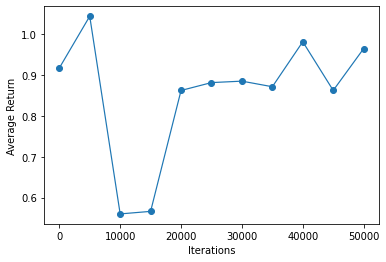

In [ ]:
print(eval_interval)
# evals = range(0, num_iterations+1, eval_interval); print(f"evals: {evals}, \nlist(evals): {list(evals)}, \nreturns: {returns}")
evals = range(0, global_step.numpy()+1, eval_interval); print(f"evals: {evals}, \nlist(evals): {list(evals)}, \nreturns: {returns}")
plt.plot(list(evals), returns)
plt.scatter(list(evals), returns)
plt.xlabel('Iterations')
plt.ylabel('Average Return')
# plt.ylim(top=50)

its: range(0, 50000), 
list(its): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

Text(0, 0.5, 'Loss')

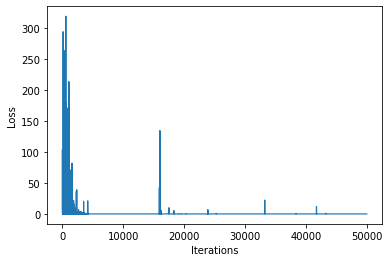

In [ ]:
its = range(0, global_step.numpy()); print(f"its: {its}, \nlist(its): {list(its)}, \nlosses: {losses}")
plt.plot(losses)
# plt.plot([e.numpy() for e in losses])
# plt.scatter(list(its), losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

##### 3.2.6.3 Save returns & losses

In [ ]:
# 
# Save returns
with open(returns_pkl_file, "wb") as fp: pickle.dump(returns, fp)
# Save losses
with open(losses_pkl_file, "wb") as fp: pickle.dump(losses, fp)

##### 3.2.6.4 Save checkpoint

In [ ]:
# 
# Save checkpoint
train_checkpointer.save(global_step)
!ls -l "{checkpoint_dir}"

total 42235
-rw------- 1 root root      448 Feb  2 17:33 checkpoint
-rw------- 1 root root 10806404 Feb  2 16:11 ckpt-10000.data-00000-of-00001
-rw------- 1 root root     4740 Feb  2 16:11 ckpt-10000.index
-rw------- 1 root root 10806404 Feb  2 16:52 ckpt-15000.data-00000-of-00001
-rw------- 1 root root     4740 Feb  2 16:52 ckpt-15000.index
-rw------- 1 root root 10806404 Feb  2 17:33 ckpt-20000.data-00000-of-00001
-rw------- 1 root root     4740 Feb  2 17:33 ckpt-20000.index
-rw------- 1 root root 10806404 Feb  2 15:03 ckpt-5000.data-00000-of-00001
-rw------- 1 root root     4740 Feb  2 15:03 ckpt-5000.index


##### 3.2.6.5 Save policy

In [ ]:
# 
# Save policy
tf_policy_saver.save(str(policy_dir))
!ls -l "{policy_dir}"

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy5/policy/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RL/TF-Agents/InvestorProject/policy5/policy/assets


total 91
drwx------ 2 root root  4096 Feb  2 15:03 assets
-rw------- 1 root root  2798 Feb  2 17:33 policy_specs.pbtxt
-rw------- 1 root root 81158 Feb  2 17:33 saved_model.pb
drwx------ 2 root root  4096 Feb  2 17:33 variables


In [ ]:
# hide
# Restore checkpoint - just to test if the checkpointing works
#   For this to work, the whole set of objects should be recreated the same way as when the checkpoint was created.
# train_checkpointer.initialize_or_restore()
# global_step = tf.compat.v1.train.get_global_step()
# tf.print(global_step)

In [ ]:
# hide
# Restore policy - just to test if the saved policy works
#   The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.
# saved_policy = tf.compat.v2.saved_model.load(str(policy_dir))

### 3.3 Evaluation
The agent has now been trained and we can use it to manage the investor's investments.

In [ ]:
def eval_policy(pol, num_episodes=5):
  actions = np.array([0,0,0,0])
  observations = [0,0,0,0,0,0,0]
  rewards = [0]
  expenses = [0]
  home_actual_pmts = [0]
  deposit_taxables = [0]
  deposit_tax_defs = [0]
  luxury_spends = [0]
  networths = [0]
  for i in range(num_episodes):
    print(f"episode {i}")
    tstep = eval_env.reset()
    s = 0
    while not tstep.is_last():
      # if s == 100: break
      #print(f"step {s}:")
      pstep = pol.action(tstep); #tf.print(f"{pstep.action[0]}")
      action = np.array(pstep.action.numpy()[0]); #tf.print(f"action={action}")
      actions = np.vstack([actions, action])

      tstep = eval_env.step(pstep.action); #tf.print(tstep.observation[0])
      observation = np.array(tstep.observation.numpy()[0])
      observations = np.vstack([observations, observation])
      reward = np.array(tstep.reward.numpy()[0])
      rewards = np.vstack([rewards, reward])

      ke_expense,ke_home_actual_pmt,ke_deposit_taxable,ke_deposit_tax_def,ke_luxury_spend,ke_networth = eval_py_env.render() #.
      expenses = np.vstack([expenses, ke_expense])
      home_actual_pmts = np.vstack([home_actual_pmts, ke_home_actual_pmt])
      deposit_taxables = np.vstack([deposit_taxables, ke_deposit_taxable])
      deposit_tax_defs = np.vstack([deposit_tax_defs, ke_deposit_tax_def])
      luxury_spends = np.vstack([luxury_spends, ke_luxury_spend])
      networths = np.vstack([networths, ke_networth])

      s += 1
  return actions,observations,rewards, expenses,home_actual_pmts,deposit_taxables,deposit_tax_defs,luxury_spends,networths

We now setup some parameters to simulate how the client will use our model:

In [ ]:
# adjust env before EVALUATION
eval_py_env.gym.verbose = False
Investor.PAR_START_AGE = 32
Investor.PAR_RETIRE_AGE = 65
Investor.PAR_INFLATION = 0.014/12.0 #for 12 months ended December 2020; https://www.usinflationcalculator.com/inflation/current-inflation-rates/
Investor.PAR_TAX_RATE = 0.22/12.0 #https://www.businessinsider.com/personal-finance/what-tax-bracket-am-i-in-federal-income-tax
Investor.PAR_SALARY_LOW = 125000; Investor.PAR_SALARY_HIGH = 125001
Investor.PAR_EXPENSES = 0.51 #of salary
house_multiple = 140000/Investor.PAR_SALARY_LOW; print(f"house_multiple: {house_multiple}")
Investor.PAR_HOUSE_MULT_LOW = house_multiple; Investor.PAR_HOUSE_MULT_HIGH = house_multiple
Investor.PAR_MORT_INT = 0.03/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
Investor.PAR_INVEST_INT = 0.004/12.0 #https://www.bankrate.com/finance/interest-rates-forecast/
Investor.PAR_TAX_DEF_DEPOSIT_CAP = 19500 #per year https://www.irs.gov/retirement-plans/plan-participant-employee/retirement-topics-contributions
Investor.PAR_TAX_DEF_COMPANY_MATCH = 1.08 #company match

house_multiple: 1.12


#### 3.3.1 Restore policy

In [ ]:
# 
# POINT TO CHECKPOINT OF POLICY WE WANT TO USE
# tf_agent.train_step_counter.assign(50000)
# global_step = tf.compat.v1.train.get_global_step()
# tf.print(global_step)

In [ ]:
# 
# Restore policy
# The policy can be loaded without having any knowledge of what agent or 
# network was used to create it. This makes deployment of the policy easier.
saved_policy = tf.compat.v2.saved_model.load(str(policy_dir))

In [ ]:
# 
# EVALUATION
# actions,observations,rewards,expenses,home_actual_pmts,deposit_taxables,deposit_tax_defs,networths = eval_policy(tf_agent.policy, 5)
actions,observations,rewards,expenses,home_actual_pmts,deposit_taxables,deposit_tax_defs,luxury_spends,networths = eval_policy(saved_policy, 1)

episode 0


In [ ]:
num_t = len(actions[:,0]); print('Number of months:', num_t) #number of ts
print(f"Networth at age {Investor.PAR_RETIRE_AGE}: ${networths[-1][0]:,.0f}")

Number of months: 398
Networth at age 65: $3,181,499


#### 3.3.2 Visualize

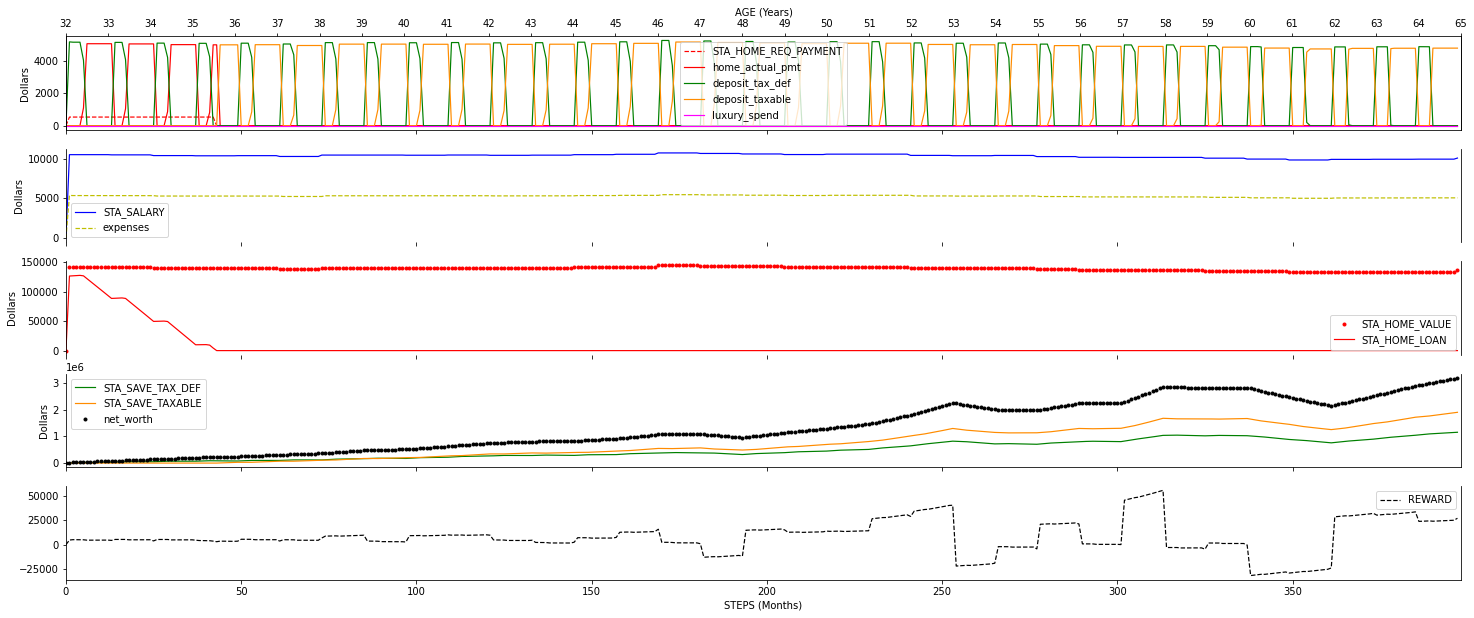

In [ ]:
mpl.rcParams['lines.linewidth'] = 1.2
t = np.arange(0, num_t); fig,(axs0,axs1,axs2,axs3,axs4) = plt.subplots(5, sharex=True)
fig.set_figwidth(25); fig.set_figheight(10)
axs0.set_ylabel('Dollars');axs1.set_ylabel('Dollars');axs2.set_ylabel('Dollars');axs3.set_ylabel('Dollars')

axs0.set_xlim(0, len(actions[:,0])); 
axs0.set_ylim(auto=True); axs0.spines['top'].set_visible(False); axs0.spines['right'].set_visible(True); axs0.spines['bottom'].set_visible(False)
axs0.plot(t, observations[:,4]*Investor.MEG, 'r--', label='STA_HOME_REQ_PAYMENT')
axs0.plot(t, home_actual_pmts[:,0], 'r-', label='home_actual_pmt')
axs0.plot(t, deposit_tax_defs[:,0], 'g-', label='deposit_tax_def')
axs0.plot(t, deposit_taxables[:,0], '-', color='darkorange', label='deposit_taxable')
axs0.plot(t, luxury_spends[:,0], '-', color='magenta', label='luxury_spend')

axs1.set_ylim(auto=True); axs1.spines['top'].set_visible(False); axs1.spines['right'].set_visible(True); axs1.spines['bottom'].set_visible(False)
axs1.plot(t, observations[:,1]*Investor.MEG, 'b-', label='STA_SALARY')
axs1.plot(t, expenses[:,0], 'y--', label='expenses')

axs2.set_ylim(auto=True); axs2.spines['top'].set_visible(False); axs2.spines['right'].set_visible(True); axs2.spines['bottom'].set_visible(False)
axs2.plot(t, observations[:,2]*Investor.MEG, 'r.', label='STA_HOME_VALUE')
axs2.plot(t, observations[:,3]*Investor.MEG, 'r-', label='STA_HOME_LOAN')

axs3.set_ylim(auto=True); axs3.spines['top'].set_visible(False); axs3.spines['right'].set_visible(True); axs3.spines['bottom'].set_visible(True)
axs3.plot(t, observations[:,5]*Investor.MEG, 'g-', label='STA_SAVE_TAX_DEF')
axs3.plot(t, observations[:,6]*Investor.MEG, '-', color='darkorange', label='STA_SAVE_TAXABLE')
axs3.plot(t, networths[:,0], 'k.', label='net_worth')

axs4.set_ylim(auto=True); axs4.spines['top'].set_visible(False); axs4.spines['right'].set_visible(True); axs4.spines['bottom'].set_visible(True)
axs4.plot(t, rewards[:,0]*Investor.MEG, 'k--', label='REWARD')
axs4.set_xlabel('STEPS (Months)')

axs0.legend(); axs1.legend(); axs2.legend(); axs3.legend(); axs4.legend()
axs_years = axs0.twiny()
years_tick_locations = np.arange(0, num_t, 12)
axs_years.set_xticks(years_tick_locations)
axs_years.set_xticklabels(range(Investor.PAR_START_AGE, Investor.PAR_START_AGE + len(years_tick_locations)))
axs_years.set_xlabel('AGE (Years)'); axs0.spines['bottom'].set_visible(False)

#### 3.3.3 Interpretation
In this episode the client chose to start with a plan at age 32 and to retire at age 65. Following this plan, the client is expected to have a networth of $3,181,499 at retirement. It is interesting how the agent learned not to assign any funds to luxury spending (magenta curve in top chart), as this does not lead to any reward (just the way the environment was setup). This could be addressed in an improved model of the investor/environment.

The agent recommends a strategy of first putting savings in the tax-deferred account each month until the annual government cap of $19,500 is reached (top chart). It then overpays on the home loan for the rest of the year. Note STA_HOME_REQ_PAYMENT, the required payment, is much lower (dotted red curve).

Once the home loan is paid off after only 3 and a half years, the agent substitutes taxable savings. The bottom chart shows the reward signal which is the month-to-month increase/decrease in networth.

Overall, the agent seems to have learned a sensible strategy.

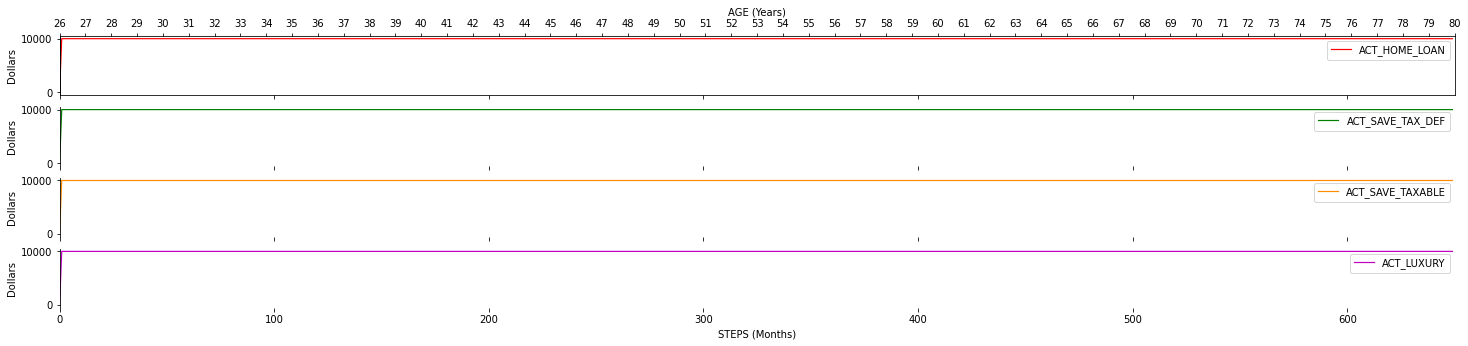

In [ ]:
#hide
t = np.arange(0, num_t); fig,axs = plt.subplots(4, sharex=True)
fig.set_figwidth(25); fig.set_figheight(5)
axs0.set_xlim(0, num_t); 
# axs0.set_ylabel('');axs1.set_ylabel('Dollars');axs2.set_ylabel('Dollars');axs3.set_ylabel('Dollars');axs4.set_ylabel('Dollars');
for a in axs:
  a.set_xlim(0, num_t); #a.set_ylim(-0.1, 1.1)
  a.set_ylabel('Dollars')
  a.spines['top'].set_visible(False); a.spines['right'].set_visible(False); a.spines['bottom'].set_visible(False); a.spines['bottom'].set_visible(False)
axs[0].plot(t, actions[:,Investor.ACT_HOME_LOAN]*Investor.MEG, 'r-', label='ACT_HOME_LOAN')
axs[1].plot(t, actions[:,Investor.ACT_SAVE_TAX_DEF]*Investor.MEG, 'g-', label='ACT_SAVE_TAX_DEF')
axs[2].plot(t, actions[:,Investor.ACT_SAVE_TAXABLE]*Investor.MEG, '-', color='darkorange', label='ACT_SAVE_TAXABLE')
axs[3].plot(t, actions[:,Investor.ACT_LUXURY]*Investor.MEG, 'm-', label='ACT_LUXURY');
for a in axs: a.legend()
axs[3].set_xlabel('STEPS (Months)')
axs_years = axs[0].twiny()
years_tick_locations = np.arange(0, num_t, 12)
axs_years.set_xticks(years_tick_locations)
axs_years.set_xticklabels(range(Investor.PAR_START_AGE, Investor.PAR_START_AGE + len(years_tick_locations)))
axs_years.set_xlabel('AGE (Years)'); axs[0].spines['bottom'].set_visible(False)